# Section 1: Business Understanding
    This is project about power usage data analysis. the data is real data of a Tranformer Area. The enegry data is measured by smart electronic meters (Meter). The data from meter is collected by a Terminal via PLC (Power Line Control Technology) one time per day include then report to server. It will be saved in the database in the database server:
    - Voltage U(V),
    - Current I(A),
    - Forward Active Energy A+(KWh)
    - Forward ReActive Energy R+(KWh)
    - Reverse Active Energy A-(KWh)
    - Reverse ReActive Energy R-(KWh)
    With multi tariff meter it have more data of each tariff :
    - Forward Active Energy tariff 1 A1+(KWh)
    - Forward Active Energy tariff 2 A2+(KWh)
    - Forward Active Energy tariff 3 A3+(KWh)
    - Forward Active Energy tariff 4 A3+(KWh)
    - Forward ReActive Energy tariff 1 R1+(Kvarh)
    - Forward ReActive Energy tariff 2 R2+(Kvarh)
    - Forward ReActive Energy tariff 3 R3+(Kvarh)
    - Forward ReActive Energy tariff 4 R3+(Kvarh)
    - Reverse Active Energy tariff 1 A1-(KWh)
    - Reverse Active Energy tariff 2 A2-(KWh)
    - Reverse Active Energy tariff 3 A3-(KWh)
    - Reverse Active Energy tariff 4 A3-(KWh)
    - Reverse ReActive Energy tariff 1 R1-(Kvarh)
    - Reverse ReActive Energy tariff 2 R2-(Kvarh)
    - Reverse ReActive Energy tariff 3 R3-(Kvarh)
    - Reverse ReActive Energy tariff 4 R3-(Kvarh)
    With this project we will know how about the Power data will be use in Power Company. It will clear how to analyze and evaluate the accuracy of data, detect electrical fraud, detect abnormal data if any... !

- Question 1 : How many meter in Tranformer Area ? How many meter is running (Active Meter )? How many meter of each model ?
- Question 2 : How about Success rate of each data that system can collect from meter as each day ? It need to show the chart to show the success rate of last 30 day ?
- Question 3 : Which each type of daily data. What is unormal data and what meter have unormal data ? Show the unormal data value if have ?

In [30]:
# import pandas lib as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

# Section 2: Data Understanding

In [31]:
# Get Meter List and daily data 
MeterList = pd.read_excel('../Data/19193111_MeterList.xls')
DailyForwardEnergy = pd.read_excel('../Data/19193111_Daily_Forward_Energy.xls')
DailyReverseEnergy = pd.read_excel('../Data/19193111_Daily_Reverse_Energy.xls')
DailyVoltage = pd.read_excel('../Data/19193111_Daily_Voltage.xls')
DailyCurrent = pd.read_excel('../Data/19193111_Daily_Current.xls')

# Meter List is infomation of all meter in Tranformer Area. 
# It use to know about infomation and para of meter
# It include Meter No, status of meter to clear it is running or not (mean install on grid power or not), meter Model to clear meter type in this project we just focus about single phase meter and three phase meter. 
# Other information is Customer No and Customer Name.
print('\n- MeterList: print 02 top row ----------------')
print(MeterList.head(2))

# DailyForwardEnergy is Forward Energy value of meter that collect one time per day.
# It use to know how much power that customer already used. 
# it include Meter No, time collect data and Energy value of total and each tariff
print('\n- DailyForwardEnergy: print 02 top row ----------------')
print(DailyForwardEnergy.head(2))

# DailyReverseEnergy is Reverse Energy value of meter that collect one time per day. 
# It use to know how much power that customer return to power (with customer user solar power) or meter install wrong. 
# It include Meter No, time collect data and Energy value of total and each tariff
print('\n- DailyReverseEnergy: print 02 top row ----------------')
print(DailyReverseEnergy.head(2))

# DailyVoltage is Voltage value of meter that collect one time per day. 
# It use to know how the voltage value that is one of operating parameters of the grid power. 
# It include Meter No, time collect data and voltage value of each phase
print('\n- DailyVoltage: print 02 top row ----------------')
print(DailyVoltage.head(2))

# DailyCurrent is Current value of meter that collect one time per day. 
# It use to know the Current value that is one of operating parameters of the grid power. 
# It include Meter No, time collect data and Current value of each phase
print('\n- DailyCurrent: print 02 top row ----------------')
print(DailyCurrent.head(2))


- MeterList: print 02 top row ----------------
   Meter_No   Status Meter_Model Customer_No         Customer_Name
0  19205924  Running     MM11-V1     T04.001  Nguyễn Văn Trình MĐK
1  19205923  Running     MM11-V1     T04.002     Nguyễn Văn Đệ MĐK

- DailyForwardEnergy: print 02 top row ----------------
   Meter_No            Data_Time  Active_energy_total  Active_energy_tariff1  \
0  19205403  2022-09-18 00:00:00              9772.50                    NaN   
1  19205403  2022-09-17 00:00:00              9758.77                    NaN   

   Active_energy_tariff2  Active_energy_tariff3  Active_energy_tariff4  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   

   Reactive_energy_total  Reactive_energy_tariff1  Reactive_energy_tariff2  \
0                    NaN                      NaN                      NaN   
1                    NaN                      NaN                      NaN

# Section 3: Data Preparation

In [32]:
# Normal we just handel data with Meter that is runnign on grid power. So we must get Meter have Status is Running (ActiveMeter)
ActiveMeterList = MeterList[(MeterList.Status == 'Running')]

# Get Meter Model : MM11-V1 is single phase meter, MM31/38 is Three phase meter
MeterModel = ActiveMeterList.Meter_Model.drop_duplicates()

# Get Single Phase Meter. With single phase meter it just inlcude a phase so it just have voltage and current value of phase L1
SinglePhaseMeterList = ActiveMeterList[(ActiveMeterList.Meter_Model == 'MM11-V1')]

# Get Three Phase Meter. With three phase meter it inlcude three phase so it will have voltage and current value of phase L1, Phase L2 and Phase L3
ThreePhaseMeterList = ActiveMeterList[(ActiveMeterList.Meter_Model == 'MM31/38')]

In [33]:
# DEF function for Data Preparation
def DataPreparation(ActiveMeterList,DailyData):
    # Add column Flag Time By Day
    DailyData['Flag_Time_By_Day'] = DailyData.Data_Time.str.slice(0, 10)

    # Join Daily data with meter List by Meter_No
    ActiveMeterListWithDailyData=ActiveMeterList.set_index('Meter_No').join(DailyData.set_index('Meter_No'))

    # Get list Day had collected data from Active Meter List
    DataByDay = DailyData.Flag_Time_By_Day.drop_duplicates()
    
    # Get Success rate of Data by Day
    Output= pd.DataFrame()
    Output['Day'] = DataByDay.copy()
    Success_Rate=[]
    for item in Output['Day']:
        TempData = ActiveMeterListWithDailyData[ActiveMeterListWithDailyData.Flag_Time_By_Day==item]
        Success_Rate.append(round(TempData.shape[0]*100/ActiveMeterList.shape[0],2))
        
    Output['Success_Rate'] = Success_Rate
    
    return ActiveMeterListWithDailyData, Output

In [34]:
# Active Meter List With Voltage Data And Success Rate Data (how many meter have voltage data in day per total active meter)
ActiveMeterListWithVoltageData, SuccessRateVoltageData = DataPreparation(ActiveMeterList,DailyVoltage)

# Active Meter List With Current Data And Success Rate Data (how many meter have current data in day per total active meter)
ActiveMeterListWithCurrentData, SuccessRateCurrentData = DataPreparation(ActiveMeterList,DailyCurrent)

# Active Meter List With Forward Energy Data And Success Rate Data (how many meter have rorward energy data in day per total active meter)
ActiveMeterListWithForwardEnergyData, SuccessRateForwardEnergyData = DataPreparation(ActiveMeterList,DailyForwardEnergy)

# Active Meter List With Reverse Energy Data And Success Rate Data (how many meter have reverse energy data in day per total active meter)
ActiveMeterListWithReverseEnergyData, SuccessRateReverseEnergyData = DataPreparation(ActiveMeterList,DailyReverseEnergy)

# Section 4: Evaluate the Results


## Question 1 : How many meter in Tranformer Area ? How many meter is running (Active Meter )? How many meter of each model ?

In [35]:
# To check data. We must know how many active meter need to collect data
# Get Total Meter
TotalMeter = MeterList.shape[0]
print('\n- Total Meter: {total}'.format(total=TotalMeter))

# Get Meter have status is Active
TotalActiveMeter = ActiveMeterList.shape[0]
print('\n- Total Active Meter : {totalActive}'.format(totalActive=TotalActiveMeter))

# Get Meter Model : MM11-V1 is single phase meter, MM31/38 is Three phase meter
TotalSinglePhaseMeter = SinglePhaseMeterList.shape[0]
TotalThreePhaseMeter = ThreePhaseMeterList.shape[0]
print('\n- Total Sing Meter : {first}; Total Three Phase Meter : {second}'.format(first=TotalSinglePhaseMeter,second=TotalThreePhaseMeter))



- Total Meter: 151

- Total Active Meter : 151

- Total Sing Meter : 143; Total Three Phase Meter : 8


## Question 2 : How about Success rate of each data that system can collect from meter as each day ? It need to show the chart to show the success rate of last 30 day ?

In [36]:
# With daily data, we need to check the data collect from meter enough or not, check the data is normal or not. it is Success rate. DEF function for show Data Rate
def ShowDataRate(SuccessRateData,DataName,NumberDays): 
    # Show Success rate of last        
    print('\n- Success rate of daily {first} data of lase {second}:\n {third}'.format(first=DataName,second=NumberDays,third=SuccessRateData.head(NumberDays)))
    
    # Show Chart of Success_Rate by Day
    # create data
    SuccessRateData = SuccessRateData.sort_values(by=['Day'])
    x=SuccessRateData['Day'].head(NumberDays)
    y=SuccessRateData['Success_Rate'].head(NumberDays)

    # Change the style of plot
    plt.figure(figsize=(18, 9))
    plt.xticks(rotation = 90)
    plt.style.use('seaborn-darkgrid')
    
    # Make the same graph
    plt.fill_between( x, y, color="skyblue", alpha=0.3)
    plt.plot(x, y, color="skyblue")
    
    # Add title and axis names
    plt.title('Success rate of collect {first} data last {second} days'.format(first=DataName,second=NumberDays))
    plt.xlabel('Day')
    plt.ylabel('Success rate (%)')
    
    # Show graph
    plt.show()


- DAILY VOLTAGE DATA


- Success rate of daily Voltage data of lase 30:
            Day  Success_Rate
0   2022-09-18         88.08
1   2022-09-17         88.08
2   2022-09-16         88.08
3   2022-09-15         88.08
4   2022-09-14         88.08
5   2022-09-13         88.08
6   2022-09-12         88.08
7   2022-09-11         88.08
8   2022-09-10         88.08
9   2022-09-09         88.08
10  2022-09-08         88.08
11  2022-09-07         88.08
12  2022-09-06         88.08
13  2022-09-05         88.08
14  2022-09-04         88.08
15  2022-09-03         88.08
16  2022-09-02         88.08
17  2022-09-01         88.08
18  2022-08-31         88.08
19  2022-08-30         88.08
20  2022-08-29         88.08
21  2022-08-28         88.08
22  2022-08-27         88.08
23  2022-08-26         88.08
24  2022-08-25         88.08
25  2022-08-24         88.08
26  2022-08-23         88.08
27  2022-08-22         88.08
28  2022-08-21         88.08
29  2022-08-20         88.08


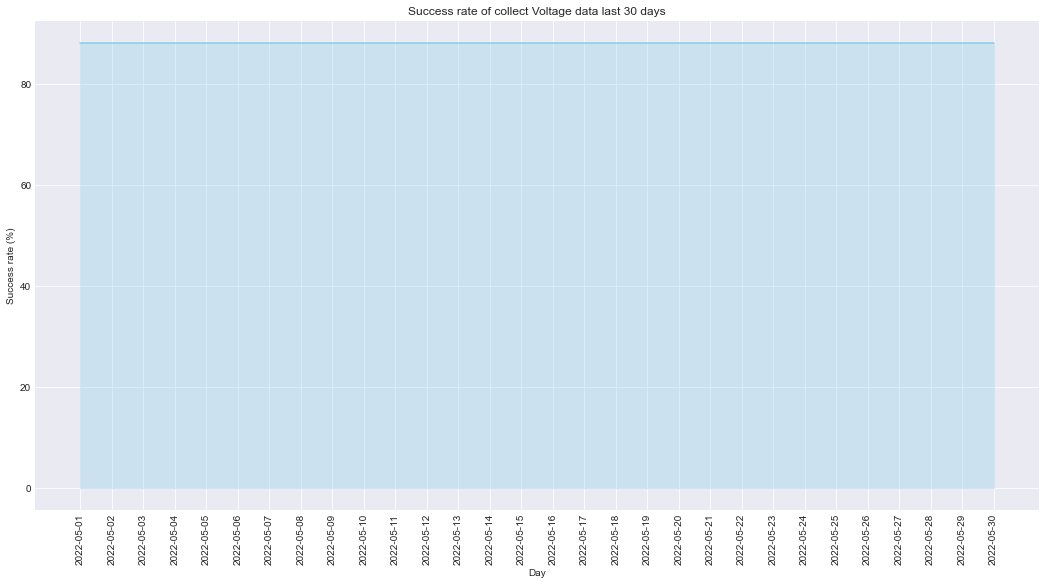

In [37]:
ShowDataRate(SuccessRateVoltageData,'Voltage',30)

- DAILY CURRENT DATA


- Success rate of daily Current data of lase 30:
            Day  Success_Rate
0   2022-09-18         87.42
1   2022-09-17         87.42
2   2022-09-16         87.42
3   2022-09-15         87.42
4   2022-09-14         87.42
5   2022-09-13         87.42
6   2022-09-12         87.42
7   2022-09-11         87.42
8   2022-09-10         87.42
9   2022-09-09         87.42
10  2022-09-08         87.42
11  2022-09-07         87.42
12  2022-09-06         87.42
13  2022-09-05         87.42
14  2022-09-04         87.42
15  2022-09-03         87.42
16  2022-09-02         87.42
17  2022-09-01         87.42
18  2022-08-31         87.42
19  2022-08-30         87.42
20  2022-08-29         87.42
21  2022-08-28         87.42
22  2022-08-27         87.42
23  2022-08-26         87.42
24  2022-08-25         87.42
25  2022-08-24         87.42
26  2022-08-23         87.42
27  2022-08-22         87.42
28  2022-08-21         87.42
29  2022-08-20         87.42


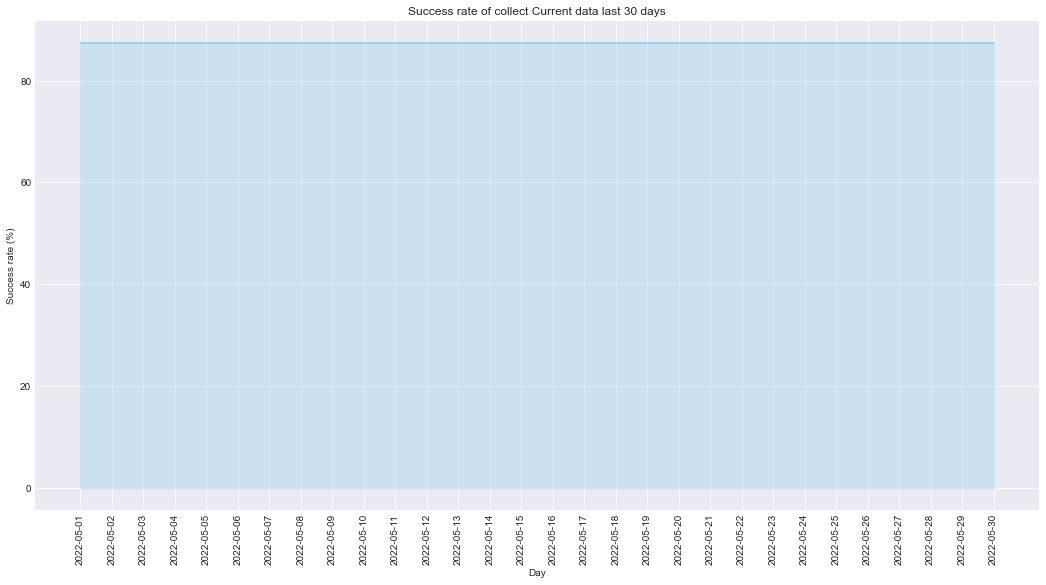

In [38]:
ShowDataRate(SuccessRateCurrentData,'Current',30)

- DAILY FORWARD ENERGY DATA


- Success rate of daily Forward Energy data of lase 30:
            Day  Success_Rate
0   2022-09-18        100.00
1   2022-09-17        100.00
2   2022-09-16        100.00
3   2022-09-15        100.00
4   2022-09-14        100.00
5   2022-09-13        100.00
6   2022-09-12        100.00
7   2022-09-11        100.00
8   2022-09-10        100.00
9   2022-09-09        100.00
10  2022-09-08        100.00
11  2022-09-07        100.00
12  2022-09-06        100.00
13  2022-09-05        100.00
14  2022-09-04        100.00
15  2022-09-03        100.00
16  2022-09-02        100.00
17  2022-09-01        100.00
18  2022-08-31        100.00
19  2022-08-30        100.00
20  2022-08-29        100.00
21  2022-08-28        100.00
22  2022-08-27        100.00
23  2022-08-26        100.00
24  2022-08-25        100.00
25  2022-08-24        100.00
26  2022-08-23        100.00
27  2022-08-22         99.34
28  2022-08-21         99.34
29  2022-08-20         99.34


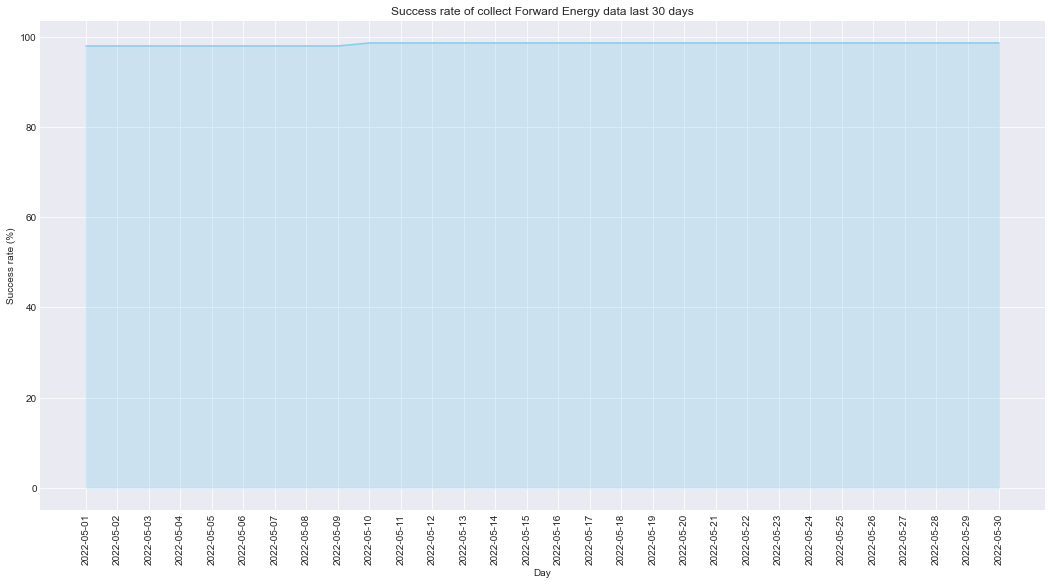

In [39]:
ShowDataRate(SuccessRateForwardEnergyData,'Forward Energy',30)

- DAILY REVERSE ENERGY DATA


- Success rate of daily Reverse Energy data of lase 30:
            Day  Success_Rate
0   2022-09-18         92.72
1   2022-09-17         92.72
2   2022-09-16         92.72
3   2022-09-15         92.72
4   2022-09-14         92.72
5   2022-09-13         92.72
6   2022-09-12         92.72
7   2022-09-11         92.72
8   2022-09-10         92.72
9   2022-09-09         92.72
10  2022-09-08         92.72
11  2022-09-07         92.72
12  2022-09-06         92.72
13  2022-09-05         92.72
14  2022-09-04         92.72
15  2022-09-03         92.72
16  2022-09-02         92.72
17  2022-09-01         92.72
18  2022-08-31         92.72
19  2022-08-30         92.72
20  2022-08-29         92.72
21  2022-08-28         92.72
22  2022-08-27         92.72
23  2022-08-26         92.72
24  2022-08-25         92.72
25  2022-08-24         92.72
26  2022-08-23         92.72
27  2022-08-22         92.72
28  2022-08-21         92.72
29  2022-08-20         92.72


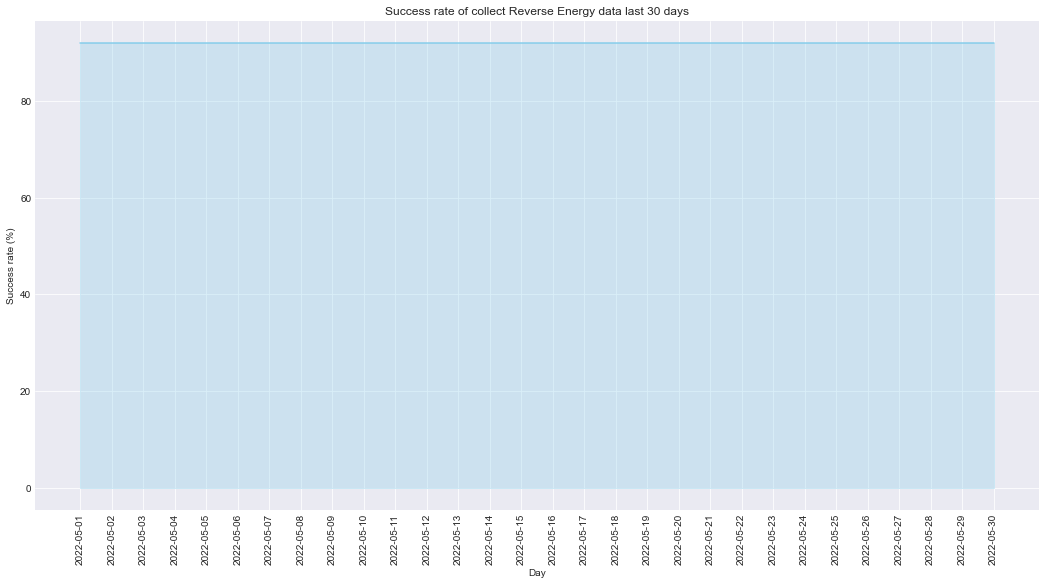

In [40]:
ShowDataRate(SuccessRateReverseEnergyData,'Reverse Energy',30)

## Question 3 : Which each type of daily data. What is unormal data and what meter have unormal data ? Show the unormal data value if have ?

- DAILY VOLTAGE DATA

In [41]:
# Voltage at Viet Nam normal from 176 V to 264 V. Check unormal data
max = 264
min = 176
UnormalVoltageData = ActiveMeterListWithVoltageData[((ActiveMeterListWithVoltageData.Voltage_in_phase_L1>max)|
                                                    (ActiveMeterListWithVoltageData.Voltage_in_phase_L1<min))|
                                                     ((ActiveMeterListWithVoltageData.Voltage_in_phase_L2>max)|
                                                    (ActiveMeterListWithVoltageData.Voltage_in_phase_L2<min))|
                                                     ((ActiveMeterListWithVoltageData.Voltage_in_phase_L3>max)|
                                                    (ActiveMeterListWithVoltageData.Voltage_in_phase_L3<min))]

TotalUnormalVoltageData = UnormalVoltageData.shape[0]
print('\n- Unormal Voltage Data :\n+ Total: {first} \n+ Detail:\n{second}'.format(first=TotalUnormalVoltageData,second=UnormalVoltageData))

# Three Phase meter normal must have voltage value of all Phase. Check unormal data. Just check with meter can collect data

VoltageDataThreePhaseMeter = ActiveMeterListWithVoltageData[ActiveMeterListWithVoltageData.Meter_Model=='MM31/38']
if VoltageDataThreePhaseMeter.shape[0]>0:
    VoltageDataThreePhaseMeter['CheckPhase1'] = VoltageDataThreePhaseMeter['Voltage_in_phase_L1'].isnull()
    VoltageDataThreePhaseMeter['CheckPhase2'] = VoltageDataThreePhaseMeter['Voltage_in_phase_L2'].isnull()
    VoltageDataThreePhaseMeter['CheckPhase3'] = VoltageDataThreePhaseMeter['Voltage_in_phase_L3'].isnull()

    UnormalVoltageDataThreePhaseMeter = VoltageDataThreePhaseMeter[((VoltageDataThreePhaseMeter.CheckPhase1==True)|
                                                                        (VoltageDataThreePhaseMeter.CheckPhase2==True)|
                                                                        (VoltageDataThreePhaseMeter.CheckPhase3==True))&
                                                                        ((VoltageDataThreePhaseMeter.CheckPhase1==False)|
                                                                        (VoltageDataThreePhaseMeter.CheckPhase2==False)|
                                                                        (VoltageDataThreePhaseMeter.CheckPhase3==False))]

    TotalUnormalVoltageDataThreePhaseMeter = UnormalVoltageDataThreePhaseMeter.shape[0]
    print('\n- Unormal Voltage Data Three Phase Meter :\n+ Total: {first} \n+ Detail:\n{second}'.format(first=TotalUnormalVoltageDataThreePhaseMeter,second=UnormalVoltageDataThreePhaseMeter))
else:
    print('\n- Do not have Current Data of Three Phase Meter')  


- Unormal Voltage Data :
+ Total: 3 
+ Detail:
           Status Meter_Model Customer_No           Customer_Name  \
Meter_No                                                            
19205403  Running     MM11-V1     T04.144           Đỗ Quốc Triệu   
19205409  Running     MM11-V1     T04.134              Đỗ Sào Nam   
19362985  Running     MM31/38     T04.014  Quách Thị Hằng 2 3FMĐK   

          Voltage_in_phase_L1  Voltage_in_phase_L2  Voltage_in_phase_L3  \
Meter_No                                                                  
19205403                170.0                  NaN                  NaN   
19205409                272.0                  NaN                  NaN   
19362985                170.0                170.0                170.0   

                    Data_Time Flag_Time_By_Day  
Meter_No                                        
19205403  2022-09-07 00:00:00       2022-09-07  
19205409  2022-08-19 00:00:00       2022-08-19  
19362985  2022-09-07 00:00:00     

- DAILY CURRENT DATA

In [42]:
# Current range of single phase meter is 0 - 80A (Imax = 80A), Three phase meter is 0 - 100A (Imax = 100A). Meter can run normal if Current value < 120% Imax. Check Meter have unomal Current
ImaxSinglePhaseMeter = 80
ImaxThreePhaseMeter = 100

# Check Current range of single phase meter
CurrentDataSinglePhaseMeter = ActiveMeterListWithCurrentData[ActiveMeterListWithCurrentData.Meter_Model=='MM11-V1']

if CurrentDataSinglePhaseMeter.shape[0]>0:
    UnormalCurrentDataSinglePhaseMeter = CurrentDataSinglePhaseMeter[CurrentDataSinglePhaseMeter.Current_in_phase_L1>ImaxSinglePhaseMeter]

    TotalUnormalCurrentDataSinglePhaseMeter = UnormalCurrentDataSinglePhaseMeter.shape[0]
    print('\n- Unormal Current Data Single Phase Meter :\n+ Total: {first} \n+ Detail:\n{second}'.format(first=TotalUnormalCurrentDataSinglePhaseMeter,second=UnormalCurrentDataSinglePhaseMeter))
else:
    print('\n- Do not have Current Data of Single Phase Meter')    
# Check Current range of single phase meter

CurrentDataThreePhaseMeter = ActiveMeterListWithCurrentData[ActiveMeterListWithCurrentData.Meter_Model=='MM31/38']
if CurrentDataThreePhaseMeter.shape[0]>0:
    UnormalCurrentDataThreePhaseMeter = CurrentDataThreePhaseMeter[(CurrentDataThreePhaseMeter.Current_in_phase_L1>ImaxThreePhaseMeter)|
                                                                (CurrentDataThreePhaseMeter.Current_in_phase_L2>ImaxThreePhaseMeter)|
                                                                (CurrentDataThreePhaseMeter.Current_in_phase_L3>ImaxThreePhaseMeter)]

    TotalUnormalCurrentDataThreePhaseMeter = UnormalCurrentDataThreePhaseMeter.shape[0]
    print('\n- Unormal Current Data Three Phase Meter :\n+ Total: {first} \n+ Detail:\n{second}'.format(first=TotalUnormalCurrentDataThreePhaseMeter,second=UnormalCurrentDataThreePhaseMeter))
else:
    print('\n- Do not have Current Data of Three Phase Meter')    


- Unormal Current Data Single Phase Meter :
+ Total: 0 
+ Detail:
Empty DataFrame
Columns: [Status, Meter_Model, Customer_No, Customer_Name, Data_Time, Current_in_phase_L1, Current_in_phase_L2, Current_in_phase_L3, Flag_Time_By_Day]
Index: []

- Unormal Current Data Three Phase Meter :
+ Total: 0 
+ Detail:
Empty DataFrame
Columns: [Status, Meter_Model, Customer_No, Customer_Name, Data_Time, Current_in_phase_L1, Current_in_phase_L2, Current_in_phase_L3, Flag_Time_By_Day]
Index: []


- DAILY FORWARD ENERGY DATA

In [43]:
# Normal Data of Enegry is the value >=0. Check that
UnormalEnegryDataCheckValue = ActiveMeterListWithForwardEnergyData[(ActiveMeterListWithForwardEnergyData.Active_energy_total < 0) |
                                 (ActiveMeterListWithForwardEnergyData.Active_energy_tariff1 < 0) | 
                                 (ActiveMeterListWithForwardEnergyData.Active_energy_tariff2 < 0) | 
                                 (ActiveMeterListWithForwardEnergyData.Active_energy_tariff3 < 0) | 
                                 (ActiveMeterListWithForwardEnergyData.Active_energy_tariff4 < 0) |
                                 (ActiveMeterListWithForwardEnergyData.Reactive_energy_total < 0) |
                                 (ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff1 < 0) | 
                                 (ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff2 < 0) | 
                                 (ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff3 < 0) | 
                                 (ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff4 < 0)]

TotalUnormalEnegryDataCheckValue = UnormalEnegryDataCheckValue.shape[0]
print('\n- Unormal Enegery (Enegry value <0) :\n+ Total: {first} \n+ Detail:\n{second}'.format(first=TotalUnormalEnegryDataCheckValue,second=UnormalEnegryDataCheckValue))


# With multi tariff meter TotalEnegry = (99% - 101%) of (EnegryTariff1 + EnegryTariff2 + EnegryTariff3 + EnegryTariff4). Check that
minvalue = 0.99
maxvalue = 1.01
UnormalEnegryDataCheckTotalAndTariffValue = ActiveMeterListWithForwardEnergyData[((ActiveMeterListWithForwardEnergyData.Active_energy_total < (ActiveMeterListWithForwardEnergyData.Active_energy_tariff1 + ActiveMeterListWithForwardEnergyData.Active_energy_tariff2 + ActiveMeterListWithForwardEnergyData.Active_energy_tariff3 + ActiveMeterListWithForwardEnergyData.Active_energy_tariff4)*minvalue)|
                                               (ActiveMeterListWithForwardEnergyData.Active_energy_total > (ActiveMeterListWithForwardEnergyData.Active_energy_tariff1 + ActiveMeterListWithForwardEnergyData.Active_energy_tariff2 + ActiveMeterListWithForwardEnergyData.Active_energy_tariff3 + ActiveMeterListWithForwardEnergyData.Active_energy_tariff4)*maxvalue))|
                                               ((ActiveMeterListWithForwardEnergyData.Reactive_energy_total < (ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff1 + ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff2 + ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff3 + ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff4)*minvalue)|
                                               (ActiveMeterListWithForwardEnergyData.Reactive_energy_total > (ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff1 + ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff2 + ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff3 + ActiveMeterListWithForwardEnergyData.Reactive_energy_tariff4)*maxvalue))]

TotalUnormalEnegryDataCheckTotalAndTariffValue = UnormalEnegryDataCheckTotalAndTariffValue.shape[0]
print('\n- With multi tariff meter, Unormal Enegery (TotalEnegry not same with (EnegryTariff1 + EnegryTariff2 + EnegryTariff3 + EnegryTariff4)) :\n+ Total: {first} \n+ Detail:\n{second}'.format(first=TotalUnormalEnegryDataCheckTotalAndTariffValue,second=UnormalEnegryDataCheckTotalAndTariffValue))


- Unormal Enegery (Enegry value <0) :
+ Total: 0 
+ Detail:
Empty DataFrame
Columns: [Status, Meter_Model, Customer_No, Customer_Name, Data_Time, Active_energy_total, Active_energy_tariff1, Active_energy_tariff2, Active_energy_tariff3, Active_energy_tariff4, Reactive_energy_total, Reactive_energy_tariff1, Reactive_energy_tariff2, Reactive_energy_tariff3, Reactive_energy_tariff4, Flag_Time_By_Day]
Index: []

- With multi tariff meter, Unormal Enegery (TotalEnegry not same with (EnegryTariff1 + EnegryTariff2 + EnegryTariff3 + EnegryTariff4)) :
+ Total: 0 
+ Detail:
Empty DataFrame
Columns: [Status, Meter_Model, Customer_No, Customer_Name, Data_Time, Active_energy_total, Active_energy_tariff1, Active_energy_tariff2, Active_energy_tariff3, Active_energy_tariff4, Reactive_energy_total, Reactive_energy_tariff1, Reactive_energy_tariff2, Reactive_energy_tariff3, Reactive_energy_tariff4, Flag_Time_By_Day]
Index: []


- DAILY REVERSE ENERGY DATA

In [44]:
# Normal Data of Enegry is the value >=0. Check that
UnormalEnegryDataCheckValue = ActiveMeterListWithReverseEnergyData[(ActiveMeterListWithReverseEnergyData.Active_energy_total < 0) |
                                 (ActiveMeterListWithReverseEnergyData.Active_energy_tariff1 < 0) | 
                                 (ActiveMeterListWithReverseEnergyData.Active_energy_tariff2 < 0) | 
                                 (ActiveMeterListWithReverseEnergyData.Active_energy_tariff3 < 0) | 
                                 (ActiveMeterListWithReverseEnergyData.Active_energy_tariff4 < 0) |
                                 (ActiveMeterListWithReverseEnergyData.Reactive_energy_total < 0) |
                                 (ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff1 < 0) | 
                                 (ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff2 < 0) | 
                                 (ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff3 < 0) | 
                                 (ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff4 < 0)]

TotalUnormalEnegryDataCheckValue = UnormalEnegryDataCheckValue.shape[0]
print('\n- Unormal Enegery (Enegry value <0) :\n+ Total: {first} \n+ Detail:\n{second}'.format(first=TotalUnormalEnegryDataCheckValue,second=UnormalEnegryDataCheckValue))


# With multi tariff meter TotalEnegry = (99% - 101%) of (EnegryTariff1 + EnegryTariff2 + EnegryTariff3 + EnegryTariff4). Check that
minvalue = 0.99
maxvalue = 1.01
UnormalEnegryDataCheckTotalAndTariffValue = ActiveMeterListWithReverseEnergyData[((ActiveMeterListWithReverseEnergyData.Active_energy_total < (ActiveMeterListWithReverseEnergyData.Active_energy_tariff1 + ActiveMeterListWithReverseEnergyData.Active_energy_tariff2 + ActiveMeterListWithReverseEnergyData.Active_energy_tariff3 + ActiveMeterListWithReverseEnergyData.Active_energy_tariff4)*minvalue)|
                                               (ActiveMeterListWithReverseEnergyData.Active_energy_total > (ActiveMeterListWithReverseEnergyData.Active_energy_tariff1 + ActiveMeterListWithReverseEnergyData.Active_energy_tariff2 + ActiveMeterListWithReverseEnergyData.Active_energy_tariff3 + ActiveMeterListWithReverseEnergyData.Active_energy_tariff4)*maxvalue))|
                                               ((ActiveMeterListWithReverseEnergyData.Reactive_energy_total < (ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff1 + ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff2 + ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff3 + ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff4)*minvalue)|
                                               (ActiveMeterListWithReverseEnergyData.Reactive_energy_total > (ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff1 + ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff2 + ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff3 + ActiveMeterListWithReverseEnergyData.Reactive_energy_tariff4)*maxvalue))]

TotalUnormalEnegryDataCheckTotalAndTariffValue = UnormalEnegryDataCheckTotalAndTariffValue.shape[0]
print('\n- With multi tariff meter, Unormal Enegery (TotalEnegry not same with (EnegryTariff1 + EnegryTariff2 + EnegryTariff3 + EnegryTariff4)) :\n+ Total: {first} \n+ Detail:\n{second}'.format(first=TotalUnormalEnegryDataCheckTotalAndTariffValue,second=UnormalEnegryDataCheckTotalAndTariffValue))



- Unormal Enegery (Enegry value <0) :
+ Total: 0 
+ Detail:
Empty DataFrame
Columns: [Status, Meter_Model, Customer_No, Customer_Name, Data_Time, Active_energy_total, Active_energy_tariff1, Active_energy_tariff2, Active_energy_tariff3, Active_energy_tariff4, Reactive_energy_total, Reactive_energy_tariff1, Reactive_energy_tariff2, Reactive_energy_tariff3, Reactive_energy_tariff4, Flag_Time_By_Day]
Index: []

- With multi tariff meter, Unormal Enegery (TotalEnegry not same with (EnegryTariff1 + EnegryTariff2 + EnegryTariff3 + EnegryTariff4)) :
+ Total: 0 
+ Detail:
Empty DataFrame
Columns: [Status, Meter_Model, Customer_No, Customer_Name, Data_Time, Active_energy_total, Active_energy_tariff1, Active_energy_tariff2, Active_energy_tariff3, Active_energy_tariff4, Reactive_energy_total, Reactive_energy_tariff1, Reactive_energy_tariff2, Reactive_energy_tariff3, Reactive_energy_tariff4, Flag_Time_By_Day]
Index: []
